In [1]:
import numpy as np

from matplotlib import pyplot as plt

import time

import sys
sys.path.append('../velocileptors/')

from zeldovich_bispectrum import ZeldovichBispectrum
from velocileptors.Utils.loginterp import loginterp

In [2]:
Dfac = 1.0

klin, plin = np.loadtxt('planck_pk.txt', unpack=True);


A = 0.05
kstar = 0.05
rd = 2.5
w = 10


wigglefac = 1 + A * np.sin(w * np.log(klin/kstar)) * np.exp(-(klin * rd)**2/2)


lpt = ZeldovichBispectrum(klin, Dfac * wigglefac * plin, kint_max=0.5)

knw, pnw = np.loadtxt('planck_pnw_bspline.txt', unpack=True)

lpt_nw = ZeldovichBispectrum(knw, Dfac * pnw, kint_max=0.5)

(0.0, 0.3)

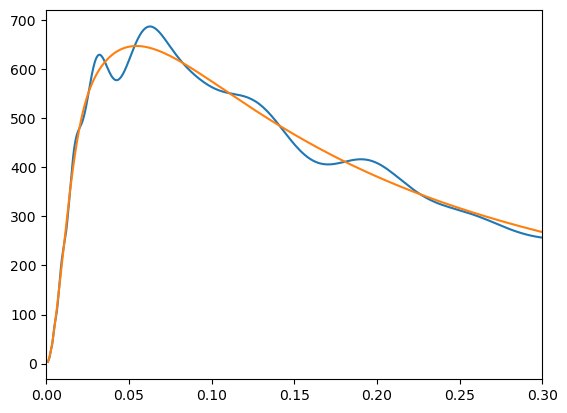

In [3]:
plt.plot(klin, klin * plin * wigglefac)

plt.plot(knw, knw * pnw)

plt.xlim(0,0.3)

(0.0, 250.0)

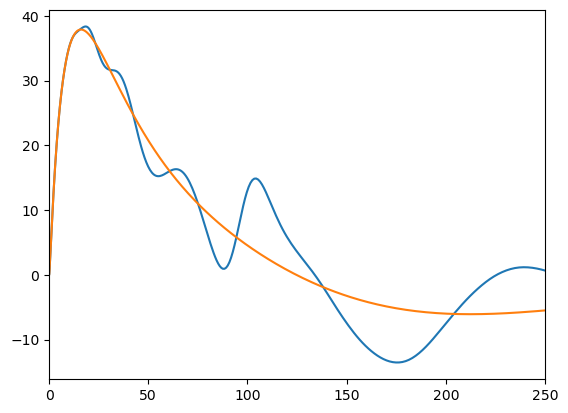

In [4]:
plt.plot(lpt.qint, lpt.qint**2 * lpt.corlin)

plt.plot(lpt.qint, lpt.qint**2 * lpt_nw.corlin)


plt.xlim(0,250)

In [5]:
from scipy.interpolate import interp1d

#plinfunc = interp1d(klin, Dfac * wigglefac * plin, kind='cubic', bounds_error=False, fill_value=1)
#pnwfunc = interp1d(klin, Dfac * pnw, kind='cubic', bounds_error=False, fill_value=1)
plinfunc = loginterp(klin, Dfac * wigglefac * plin)
pnwfunc = loginterp(klin, Dfac * pnw)
pwfunc = interp1d(klin, Dfac * (wigglefac * plin - pnw), kind='cubic', bounds_error=False, fill_value=1)

def Z2(p1vec, p2vec):
    return 0.5 * (1 + np.dot(p1vec,p2vec)/np.dot(p1vec,p1vec)) * (1 + np.dot(p1vec,p2vec)/np.dot(p2vec,p2vec))
    #return 5./7 + 0.5 * (np.dot(p1vec,p2vec)/np.dot(p1vec,p1vec) + np.dot(p1vec,p2vec)/np.dot(p2vec,p2vec))\
    #            + 2./7*np.dot(p1vec,p2vec)**2/np.dot(p2vec,p2vec)/np.dot(p1vec,p1vec)
    #return np.dot(p1vec,p2vec)**2/np.dot(p2vec,p2vec)/np.dot(p1vec,p1vec) - 1./3
    #return 1
    
def Btree(p1vec, p2vec, pfunc=plinfunc):
    
    p3vec = - (p1vec+p2vec)
    p1, p2, p3 = np.linalg.norm(p1vec), np.linalg.norm(p2vec), np.linalg.norm(p3vec)
    
    
    return 2 * (  Z2(p1vec,p2vec) * pfunc(p1) * pfunc(p2)\
                + Z2(p2vec,p3vec) * pfunc(p2) * pfunc(p3)\
                + Z2(p1vec,p3vec) * pfunc(p1) * pfunc(p3))

In [6]:
SigmaBAO = np.interp(w / klin, lpt.qint, lpt.Xlin + lpt.Ylin)

#pdampedfunc = interp1d(klin, Dfac * (pnw + np.exp(-0.5*klin**2*SigmaBAO) * (wigglefac * plin - pnw)),\
#                       kind='cubic', bounds_error=False, fill_value=1)

pdampedfunc = loginterp(klin, Dfac * (pnw + np.exp(-0.5*klin**2*SigmaBAO) * (wigglefac * plin - pnw)))

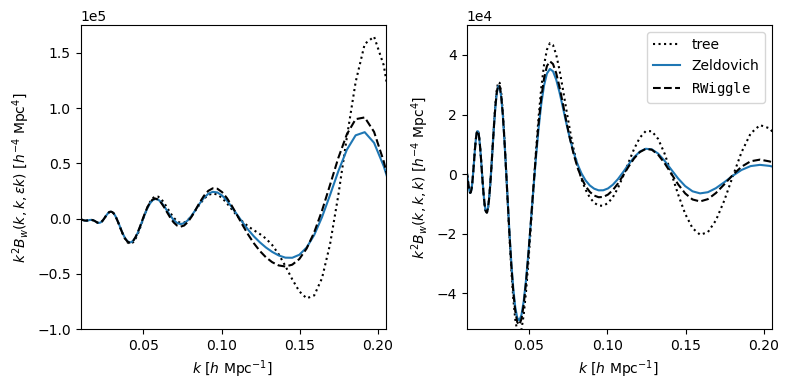

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,2)

p1hat = np.array([1,0,0])
p2hat = -np.array([0.5, np.sqrt(3)/2,0])

#ks = np.arange(0.01, 0.21, 0.0025)
ks = np.logspace(-2,np.log10(0.21), 100)

Btrees = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)
Bdamped = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=plinfunc)
    Btreenws[ii] = Btree(k*p1hat, k*p2hat, pfunc=pnwfunc)
    Bdamped[ii] = Btree(k*p1hat, k*p2hat, pfunc=pdampedfunc)
    
Bs = np.zeros_like(ks)
Bnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bs[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bnws[ii] = Binf + Bfin
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin

plt.plot(ks, ks**2 * (Btrees-Btreenws),'k:',label='tree')
plt.plot(ks, ks**2 * (Bs-Bnws), label='Zeldovich')
#plt.plot(ks, ks**2 * (Bloops-Bloopnws), label='1-loop')
plt.plot(ks, ks**2 * (Bdamped-Btreenws), 'k--', label=r'$\tt{RWiggle}$')


plt.ylim(-Dfac**2*52000, Dfac**2*50000)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


plt.xlim(0.01,0.205)
plt.legend()

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,k)$ [$h^{-4}$ Mpc$^{4}$] ')

# save data
#np.savetxt('equilateral_wiggle_curves.txt',\
#           np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
#           header='k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped\n')


#np.savetxt('equilateral_wiggle_curves.txt',\
 #          np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
 #          header='Triangle Configuration is k x ' + str(p1hat) + ', ' + str(p2hat) + '\n'  +\
  #                'k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped')

plt.subplot(1,2,1)

p1hat = np.array([-0.025,0,1])
p2hat = np.array([0.05, 0, 0])

Btrees = np.zeros_like(ks)
Btreenws = np.zeros_like(ks)
Bdamped = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Btrees[ii] = Btree(k*p1hat, k*p2hat, pfunc=plinfunc)
    Btreenws[ii] = Btree(k*p1hat, k*p2hat, pfunc=pnwfunc)
    Bdamped[ii] = Btree(k*p1hat, k*p2hat, pfunc=pdampedfunc)
    
Bs = np.zeros_like(ks)
Bnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bs[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.Bzel({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bnws[ii] = Binf + Bfin
    
Bloops = np.zeros_like(ks)
Bloopnws = np.zeros_like(ks)

for ii, k in enumerate(ks):
    
    Binf, Bfin = lpt.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloops[ii] = Binf + Bfin

    Binf, Bfin = lpt_nw.B1loop({1: k*p1hat, 2:k*p2hat, 3:-k*p1hat-k*p2hat})
    Bloopnws[ii] = Binf + Bfin
    
plt.plot(ks, ks**2 * (Btrees-Btreenws),'k:',label='tree')
plt.plot(ks, ks**2 * (Bs-Bnws))
#plt.plot(ks, ks**2 * (Bloops-Bloopnws))
plt.plot(ks, ks**2 * (Bdamped-Btreenws),'k--', label=r'$\tt{RWiggle}$')


plt.ylim(-Dfac**2*100000, Dfac**2*175000)
plt.xlim(0.01,0.205)

plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))


#plt.legend(loc='upper left')

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$] ')
plt.ylabel(r'$k^2 B_w(k,k,\epsilon k)$ [$h^{-4}$ Mpc$^{4}$] ')

plt.tight_layout()

#np.savetxt('squeezed_wiggle_curves.txt',\
#           np.array([ks, Btrees, Btreenws, Bs, Bnws, Bloops, Bloopnws, Bdamped]).T,\
 #          header='Triangle Configuration is k x ' + str(p1hat) + ', ' + str(p2hat) + '\n'  +\
 #                 'k\t Btree\t Btreenw\t BZel\t BZelnw\t Bloop\t Bloopnw\ Bdamped')

plt.savefig('squeezed_equilateral_log_wiggle.pdf')